# Predict Ride Duration 

from member type, weather (temp, rain), can we predict the duration 
- in the csv: group by day, group by member type 



In [2]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import dateutil 
import scipy 
from scipy import stats
import datetime
import random as rand
import itertools as it

from scipy.cluster import hierarchy as hier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import StratifiedKFold

%matplotlib inline 

# Read each csv file's data
# Create usable dataset 

This section creates a dataset that combines the B-Cycle and Weather datasets 


In [3]:
# # read BCycle csv data 

# bike = pd.read_csv("truncated relabeled member type.csv")
# bike['Checkout Date']= pd.to_datetime(bike['Checkout Date'])
# bike['Checkout Date'] = bike['Checkout Date'].dt.strftime('%Y/%m/%d')

# print(bike.shape)
# bike.head(5)
# bike.to_csv (r'C:\Users\Rohan Chaudhry\Desktop\bike_use.csv', index = None, header=True) 

In [4]:
# Load reformatted bike csv 
bike = pd.read_csv("bike_use.csv")
bike.head(3)

,Membership Type,Checkout Date,Checkout Time,Trip Duration Minutes
0,Explorer,2014/01/01,0:12:00,20
1,Explorer,2014/01/01,0:12:00,19
2,Explorer,2014/01/01,0:12:00,17


In [5]:
# weather csv 
weather = pd.read_csv("austin_weather.csv")
weather = weather.filter(['Date','TempAvgF','HumidityAvgPercent','PrecipitationSumInches'], axis=1)
print(weather.shape)
weather.head(3)

(1319, 4)


,Date,TempAvgF,HumidityAvgPercent,PrecipitationSumInches
0,2013-12-21,60,75,0.46
1,2013-12-22,48,68,0
2,2013-12-23,45,52,0


In [6]:
# consistent dates 
weather['Date']= pd.to_datetime(weather['Date'])
weather['Date'] = weather['Date'].dt.strftime('%Y/%m/%d')
start_date = '2014/01/01'
end_date = '2017/07/31'

mask = (weather['Date'] >= start_date) & (weather['Date'] <= end_date)

weather = weather.loc[mask]
weather = weather.reset_index(drop = True) 

weather.head(3) 

,Date,TempAvgF,HumidityAvgPercent,PrecipitationSumInches
0,2014/01/01,54,68,0
1,2014/01/02,44,55,0
2,2014/01/03,43,49,0


In [7]:
bike = bike.groupby(['Checkout Date','Membership Type']).mean()[['Trip Duration Minutes']]
bike.head(10) 

Trip Duration Minutes
Checkout Date Membership Type                       
2014/01/01    Explorer                     43.991770
              Local365                     33.857143
              National                     11.333333
              Other                         8.000000
              SevenDay                     13.000000
2014/01/02    Explorer                     24.348214
              Local365                      7.200000
              National                      6.000000
              Other                         7.461538
              SevenDay                     11.625000

# Combine the Datasets 
- Multilevel index 

In [8]:
bike.index.levels[0].name = 'Date' 
# print(bike.index.levels[1].name) --> Membership Type 
bike.head(10)

Trip Duration Minutes
Date       Membership Type                       
2014/01/01 Explorer                     43.991770
           Local365                     33.857143
           National                     11.333333
           Other                         8.000000
           SevenDay                     13.000000
2014/01/02 Explorer                     24.348214
           Local365                      7.200000
           National                      6.000000
           Other                         7.461538
           SevenDay                     11.625000

In [9]:
weather.head(10) 

,Date,TempAvgF,HumidityAvgPercent,PrecipitationSumInches
0,2014/01/01,54,68,0
1,2014/01/02,44,55,0
2,2014/01/03,43,49,0
3,2014/01/04,57,68,0
4,2014/01/05,47,59,0
5,2014/01/06,29,38,0
6,2014/01/07,35,43,0
7,2014/01/08,47,75,0.16
8,2014/01/09,62,80,0
9,2014/01/10,65,81,0.1


In [10]:
# convert datatypes 
weather['TempAvgF'] =pd.to_numeric(weather['TempAvgF'], errors='coerce')
weather['HumidityAvgPercent']=pd.to_numeric(weather['HumidityAvgPercent'], errors='coerce')
weather['PrecipitationSumInches']=pd.to_numeric(weather['PrecipitationSumInches'], errors='coerce')
print(weather.dtypes)

Date                       object
TempAvgF                    int64
HumidityAvgPercent        float64
PrecipitationSumInches    float64
dtype: object


In [11]:
# set index 
weather.set_index('Date', inplace=True, drop=True)
weather.head(2)

,TempAvgF,HumidityAvgPercent,PrecipitationSumInches
Date,,,
2014/01/01,54,68.0,0.0
2014/01/02,44,55.0,0.0


In [12]:
print(bike.dtypes)

Trip Duration Minutes    float64
dtype: object


In [13]:
firsts = bike.index.get_level_values('Date')
print(firsts)

Index(['2014/01/01', '2014/01/01', '2014/01/01', '2014/01/01', '2014/01/01',
       '2014/01/02', '2014/01/02', '2014/01/02', '2014/01/02', '2014/01/02',
       ...
       '2017/07/30', '2017/07/30', '2017/07/30', '2017/07/30', '2017/07/31',
       '2017/07/31', '2017/07/31', '2017/07/31', '2017/07/31', '2017/07/31'],
      dtype='object', name='Date', length=7169)


In [14]:
print(weather.index.name)

Date


In [15]:
w2 = weather[['TempAvgF']].copy() 
w3 = weather[['HumidityAvgPercent']].copy() 
w4 = weather[['PrecipitationSumInches']].copy() 
w2.head(2) 

,TempAvgF
Date,
2014/01/01,54
2014/01/02,44


# Show Combined Dataframe


In [16]:
# confirm merged DataFrame 

bike['TempAvgF'] = w2.loc[firsts].values
bike['HumidityAvgPercent'] = w3.loc[firsts].values
bike['PrecipitationSumInches'] = w4.loc[firsts].values

bike.head(20)

Trip Duration Minutes  TempAvgF  \
Date       Membership Type                                    
2014/01/01 Explorer                     43.991770        54   
           Local365                     33.857143        54   
           National                     11.333333        54   
           Other                         8.000000        54   
           SevenDay                     13.000000        54   
2014/01/02 Explorer                     24.348214        44   
           Local365                      7.200000        44   
           National                      6.000000        44   
           Other                         7.461538        44   
           SevenDay                     11.625000        44   
2014/01/03 Explorer                     52.487805        43   
           Local365                     13.200000        43   
           Other                         5.250000        43   
           SevenDay                      3.333333        43   
2014/01/04 Explorer                     44.257143        57   
           Local365                     14.153846        57   
           Other                         9.800000        57   
           SevenDay                     18.500000        57   
2014/01/05 Explorer                     21.371429        47   
           Local365                     10.777778        47   

                            HumidityAvgPercent  PrecipitationSumInches  
Date       Membership Type                                              
2014/01/01 Explorer                       68.0                     0.0  
           Local365                       68.0                     0.0  
           National                       68.0                     0.0  
           Other                          68.0                     0.0  
           SevenDay                       68.0                     0.0  
2014/01/02 Explorer                       55.0                     0.0  
           Local365                       55.0                     0.0  
           National                       55.0                     0.0  
           Other                          55.0                     0.0  
           SevenDay                       55.0                     0.0  
2014/01/03 Explorer                       49.0                     0.0  
           Local365                       49.0                     0.0  
           Other                          49.0                     0.0  
           SevenDay                       49.0                     0.0  
2014/01/04 Explorer                       68.0                     0.0  
           Local365                       68.0                     0.0  
           Other                          68.0                     0.0  
           SevenDay                       68.0                     0.0  
2014/01/05 Explorer                       59.0                     0.0  
           Local365                       59.0                     0.0

# Begin Cluster Analysis 

Can we predict Average Ride Duration for a membertype given: 
- humidity
- temp
- precipitation

In [17]:
# rename merged dataset to data 
data = bike 
print(data.shape)

(7169, 4)


## Data scaling & dimensionality reduction with PCA

In [18]:
# check if NaN values are present
data.isnull().sum()

# since less than 10% of total rows are NaN, drop all NaN rows 
data.dropna(inplace=True)

data.head()
# Dataframe now 6510 rows 

Trip Duration Minutes  TempAvgF  \
Date       Membership Type                                    
2014/01/01 Explorer                     43.991770        54   
           Local365                     33.857143        54   
           National                     11.333333        54   
           Other                         8.000000        54   
           SevenDay                     13.000000        54   

                            HumidityAvgPercent  PrecipitationSumInches  
Date       Membership Type                                              
2014/01/01 Explorer                       68.0                     0.0  
           Local365                       68.0                     0.0  
           National                       68.0                     0.0  
           Other                          68.0                     0.0  
           SevenDay                       68.0                     0.0

In [19]:
#split the dataset into features and labels
labels = data['Trip Duration Minutes'] 
features = data.drop('Trip Duration Minutes', axis = 1) # Temp, Humid, Prec. 

In [20]:
# create standard scaler object for labels only 
ss = StandardScaler().fit_transform(features) # use data for labels only 

# create PCA object 
pca = PCA(n_components = .95, svd_solver='full') 
pca_features = pca.fit_transform(ss)

# put transformed data back into a dataframe 
transformed_features = pd.DataFrame(pca_features) 
transformed_features.head(10) 

,0,1,2
0,-0.048104,1.269760,-0.399571
1,-0.048104,1.269760,-0.399571
2,-0.048104,1.269760,-0.399571
3,-0.048104,1.269760,-0.399571
4,-0.048104,1.269760,-0.399571
5,-0.767455,2.084713,0.279458
6,-0.767455,2.084713,0.279458
7,-0.767455,2.084713,0.279458
8,-0.767455,2.084713,0.279458
9,-0.767455,2.084713,0.279458


In [21]:
def scatter(data, labels, numPoints):
    
    numEntries = data.shape[0]
    start = rand.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data.iloc[:, :-1])
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

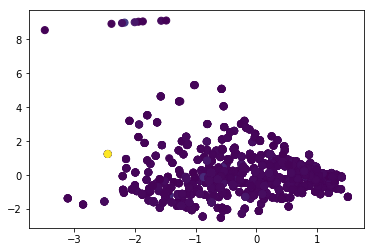

In [24]:
scatter(transformed_features, labels, numPoints=3000)
# 11 minutes to run, about 50% of dataframe 

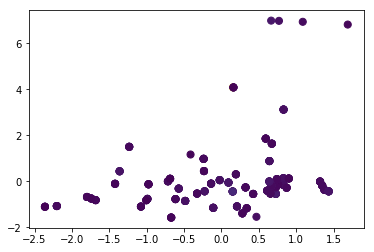

In [25]:
scatter(transformed_features, labels, numPoints=300)
# less than 10 seconds, about 5% of dataframe 

## DBSCAN Cluster

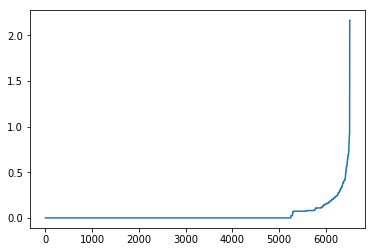

In [26]:
# Nearest Neighbors with n_neighbors = 6
nn = NearestNeighbors(6) 

# fit transformed data 
nn_fit = nn.fit(transformed_features)

# K Neighbors method to find distance of each point 
dist, idx = nn_fit.kneighbors(transformed_features)

# only look at distance to 6th nearest neighbor 
dist4 = []
for i in dist: 
    dist4.append(i[5])
dist4.sort() 

# plot distances of sixth nearest neighbor 
plt.plot(dist4)
plt.show() 

# EPS = .15 

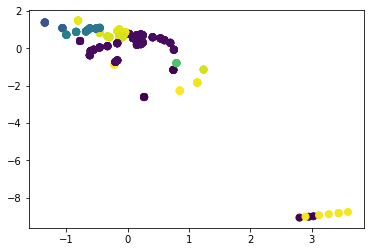

In [27]:
# DBSCAN fit predict 
clusters = DBSCAN(eps=.15, min_samples =6).fit_predict(transformed_features)

# convert return to pd series 
ser = pd.Series(clusters) 

# scatter func
scatter(transformed_features, ser, 300)

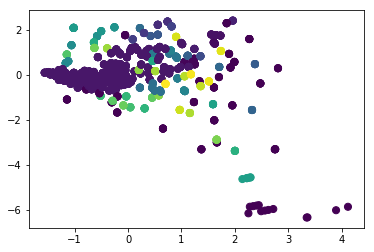

In [28]:
scatter(transformed_features, ser, 1500)
# ~ 5 min 

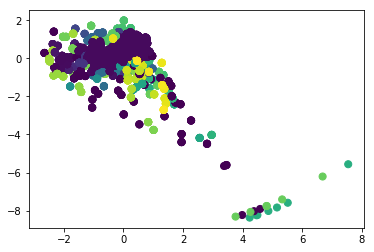

In [29]:
scatter(transformed_features, ser, 3000)
# 8 minutes 

# Cluster with K Means 

In [22]:
#cluster data using K means 
kmeans_2 = KMeans(n_clusters=2).fit_predict(transformed_features)
kmeans_3 = KMeans(n_clusters=3).fit_predict(transformed_features)
kmeans_4 = KMeans(n_clusters=4).fit_predict(transformed_features)
kmeans_5 = KMeans(n_clusters=5).fit_predict(transformed_features)
kmeans_6 = KMeans(n_clusters=6).fit_predict(transformed_features)
kmeans_7 = KMeans(n_clusters=7).fit_predict(transformed_features)
kmeans_8 = KMeans(n_clusters=8).fit_predict(transformed_features)
kmeans_9 = KMeans(n_clusters=9).fit_predict(transformed_features)
kmeans_10 = KMeans(n_clusters=10).fit_predict(transformed_features)

# convert to series 
ser2 = pd.Series(kmeans_2)
ser3 = pd.Series(kmeans_3)
ser4 = pd.Series(kmeans_4)
ser5 = pd.Series(kmeans_5)
ser6 = pd.Series(kmeans_6)
ser7 = pd.Series(kmeans_7)
ser8 = pd.Series(kmeans_8)
ser9 = pd.Series(kmeans_9)
ser10 = pd.Series(kmeans_10)

# K Means results in series 
series = [ser2,ser3,ser4,ser5,ser6,ser7,ser8,ser9,ser10] 

scores = [] # to hold corresponding silhouette scores 

for i in range (9):
    s_score = silhouette_score(transformed_features, series[i]) 
    print('K:',i+2," Silhouette Score:", s_score)
    scores.append([s_score,i+2])
    
scores.sort(key=lambda x:x[0]) # sort from worst to best score 
print('The best number of clusters is: ', scores[-1][1])

K: 2  Silhouette Score: 0.3449289691284079
K: 3  Silhouette Score: 0.39443399885495917
K: 4  Silhouette Score: 0.40337270374433265
K: 5  Silhouette Score: 0.40953433336350104
K: 6  Silhouette Score: 0.36347580443370286
K: 7  Silhouette Score: 0.3412257194770872
K: 8  Silhouette Score: 0.35344787180229514
K: 9  Silhouette Score: 0.352898681410987
K: 10  Silhouette Score: 0.3609166177925407
The best number of clusters is:  5


# Observation: Best number of clusters is 5, but there are 10 main member types

This might suggest that some Membership Types ride more similarly to each other than we may have thought. 

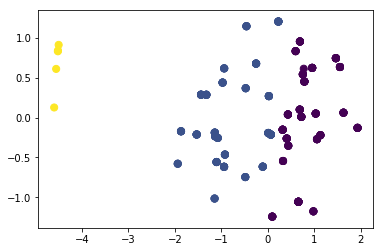

In [31]:
#plot data 
scatter(transformed_features, ser5, 300)

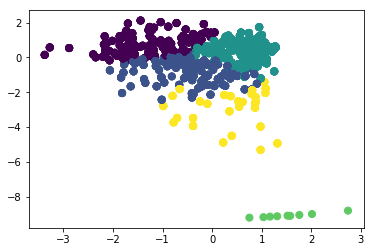

In [32]:
scatter(transformed_features, ser5, 3000)
# 10 minutes to run 

# Classify Test Points 

In [34]:
# 80% training, 20% testing 
#x_train, x_test = train_test_split(scaled_features,train_size=.8,test_size=.2)

from sklearn.model_selection import train_test_split

scaled_features = StandardScaler().fit_transform(features) 
 
print(type(scaled_features))
print(scaled_features.shape)
print(scaled_features[0])
print("mean: ", scaled_features.mean())
print("std: ", scaled_features.std())

<class 'numpy.ndarray'>
(6510, 3)
[-1.296116    0.14763397 -0.26934685]
mean:  2.364837574214363e-16
std:  0.9999999999999999


In [35]:
# 80% train, 20% test split 
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.20, random_state=None)

print(type(X_train))

print("X_train=",X_train.shape, " X_test=", X_test.shape)
print("y_train=",y_train.shape, " y_test=", y_test.shape)

<class 'numpy.ndarray'>
X_train= (5208, 3)  X_test= (1302, 3)
y_train= (5208,)  y_test= (1302,)


In [80]:
# PCA on training set 

pca = PCA()
pca_data = pca.fit_transform(X_train)

var_exp = pca.explained_variance_ratio_
print("Variance in each PC: ", var_exp,'\n')

cum_var_exp = np.cumsum(var_exp)
print("Cumulative variance: ", cum_var_exp,'\n')

n_cols = 1 + np.argmax(cum_var_exp > 0.95)
print("n_cols to keep:", n_cols,'\n')

#reduce training set to size
X_train_pca = pca_data[:, :n_cols] # all rows, columns 0 to n_cols
X_test_pca = pca.transform(X_test)[:, :n_cols] 
print (X_train_pca.shape, X_test_pca.shape) #they've both been reduced to 2 dimensions

Variance in each PC:  [0.4499317  0.33761808 0.21245022] 

Cumulative variance:  [0.4499317  0.78754978 1.        ] 

n_cols to keep: 3 

(5208, 3) (1302, 3)


# Use Descision Tree Regressor as a Classifier

In [81]:
from sklearn import tree 

clf = tree.DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=.68)
# Train it

# X_train, X_test, y_train, y_test
# X_train_pca , X_train_pca 

clf = clf.fit(X_train_pca, y_train)

# The trained tree is now stored in the variable 'clf'

In [82]:
pred_Y = clf.predict(X_test_pca)

clf2 = tree.DecisionTreeRegressor(criterion='mse', max_depth=3, min_samples_leaf = 2, max_features=.68,min_samples_split=2)

clf2 = clf2.fit(X_train_pca, y_train)

pred_y2 = clf2.predict(X_test_pca)

In [83]:
print(type(pred_y2))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [91]:
from sklearn import metrics

pred_y2 = pred_y2.reshape(1302,1)

print(y_test.shape)
print(pred_y2.shape)

(1302, 1)
(1302, 1)


In [92]:
from sklearn.model_selection import cross_val_score
sc = cross_val_score(clf,X_train, y_train,cv=10)

In [100]:
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, pred_Y)))
print('R^2:', metrics.r2_score(y_test,pred_Y))
print('Explained Variance:', metrics.explained_variance_score(y_test,pred_Y))

Mean Absolute Error: 13.305189274908379
R^2: 0.01255369851011956
Explained Variance: 0.012680019049564173


## Observation: 
- A Mean Absolute Error close to 0 reflects a strong model. 

- An R^2 value close to 0 between the test and predicted labels shows that the model is poorly trained (not linearly related). 


- A low Explained Variance Score reflects a poor model since the best possible score is 1. 
- This suggests high variance between the test and predicted label sets


In [123]:
from sklearn.model_selection import GridSearchCV

params = {"max_depth": [5,10,15,20],
          "min_samples_leaf": [5,10,15,20],
          "max_features": [.68]}


# Create the GridSearchCV object:
# Pass in  classifier, test parameters,
# num CV folds, scoring metric 
grid_search = GridSearchCV(clf, params, cv=5, scoring='explained_variance')

# start training classifiers with the different max_depths specified
# A 5-fold CV will be run for each max_depth and accuracy will be assesed for each max_depth
grid_search.fit(features, labels)

# best max_depth
print(grid_search.best_params_)

# Accuracy 
nested_score = cross_val_score(grid_search, features, labels, cv=3)
hi = 0 
for i in range(50):
    tr = nested_score.mean()*-100
    if tr > hi:
        hi = tr
print('Accuracy:', tr)

{'max_depth': 5, 'max_features': 0.68, 'min_samples_leaf': 15}
Accuracy: 41.42120456213597


In [125]:
transformed_features.shape

(6510, 3)

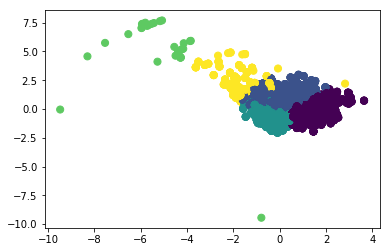

In [126]:
# Entire set 
scatter(transformed_features, ser5, 6510)

# Observation and Analysis: 
- We began this Notebook with 10 Main Member Types, but the clustering model shows that there are 5 overarching groups. 
- Ostensibly, there appears to be 3 clusters: the green, the yellow, and a combination of the blue, teal, and purple. 

From this, B-Cycle could continue analyzing weather patterns with its product use to create a more reliable model. 
This model can eventually serve two innovative purposes: 

1. Allow B-Cycle to consolidate its member and price structure
  - B-Cycle can better organize its usage information (managing 5 types is easier than 10) 
  - B-Cycle can combine similar ride groups to provide more inclusive Membership Options 
<br><br>
2. Predict usage per member group on a given day and its weather pattern 
  - Given the weather, the DTRegressor model predicted expected ride time for a member with 40% accuracy
  - Since its accuracy is 40%, we will not move forward with the model for predictive purposes
  - The model can improve its accuracy by continued feature engineering and reducing dimensionality